In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from importlib import reload
import os
from collections import Counter
from sklearn.metrics import roc_auc_score as auc
import copy
from sklearn.ensemble import HistGradientBoostingClassifier as hgbc
import pickle
import warnings
import math
import copy
import tests
import figures
from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import Ridge
warnings.filterwarnings("ignore")

import TunaSims
import func_ob
import tools
import datasetBuilder
import testUtils
import spectral_similarity
import itertools
import reweightFuncs

In [ ]:
nist14='/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist14_highres.pkl'
nist20_prot = '/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist20_prot_fiehn_.pkl'
nist20 = '/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist20.pkl'
nist23_prot = '/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist23_prot_deprot_only.pkl'
nist23='/Users/jonahpoczobutt/projects/raw_data/db_csvs/nist23_full.pkl'
gnps='/Users/jonahpoczobutt/projects/raw_data/db_csvs/gnps_highres.pkl'
mona='/Users/jonahpoczobutt/projects/raw_data/db_csvs/mona_highres.pkl'
metlin='/Users/jonahpoczobutt/projects/raw_data/db_csvs/metlin.pkl'


Discussion Points

Should we look at inchiKey for match rather than inchiCore

does spectral entropy relate to precursor m/z - yes

does spectral entropy relate to CE - yes

does peak intensity relate to m/z - meh

does peak intensity relate to CE

What factors should play into reweighting

    -for quality measure: precursor mz
    -for reducing corr: fragment mz

does having lower correlated similarity measures produce better results

can we obtain lower correlation with the same cleaning procedure in order to be memory efficient (ie thru sim measures)

Should we try sequential fitting on residuals?

incorporate into model as feature the cleanliness of spectra by comparing the entropy of spectra from entire experiment vs their expectation from combined database. Higher entropy -> lower quality when adjusted properly. Inputs could be m/z as well as CE

Create all Necessary Directories

In [ ]:
#databases
outputs_path='/Users/jonahpoczobutt/projects/TunaRes/test'

self_search=True
query = nist20
target = nist20

if query == target:
    self_search = True
    
fullRun=False
if fullRun:
    os.mkdir(outputs_path)
    os.mkdir(f'{outputs_path}/intermediateOutputs')
    os.mkdir(f'{outputs_path}/intermediateOutputs/splitMatches')
    os.mkdir(f'{outputs_path}/intermediateOutputs/gbcIndices')
    os.mkdir(f'{outputs_path}/intermediateOutputs/splitMatches/inchisBySet')
    os.mkdir(f'{outputs_path}/intermediateOutputs/splitMatches/train')
    os.mkdir(f'{outputs_path}/intermediateOutputs/splitMatches/val')
    os.mkdir(f'{outputs_path}/intermediateOutputs/splitMatches/test')
    os.mkdir(f'{outputs_path}/intermediateOutputs/splitMatches/port')
    os.mkdir(f'{outputs_path}/intermediateOutputs/datasets')
    os.mkdir(f'{outputs_path}/intermediateOutputs/datasets/train')
    os.mkdir(f'{outputs_path}/intermediateOutputs/datasets/val')
    os.mkdir(f'{outputs_path}/intermediateOutputs/datasets/test')
    os.mkdir(f'{outputs_path}/gbc_res')
    os.mkdir(f'{outputs_path}/intermediateOutputs/train_to_func')
    os.mkdir(f'{outputs_path}/intermediateOutputs/train_to_error')
    

Splt Queries into Train, Val, Test by Core or Key

In [ ]:
fullRun=True
match_category = 'inchi_base'
if fullRun:

    #This should be replaced with a function to read in all the databases
    query_ = pd.read_pickle(query)

    #jonah edit here
    all_bases = list(set(query_[match_category]))

    if self_search:
        query_.insert(0,'queryID', [i for i in range(len(query_))])
    else:
        query_.insert(0,'queryID', ["_" for i in range(len(query_))])

    #this method is in place
    np.random.shuffle(all_bases)

    first_bases = all_bases[:int(len(all_bases)*0.5)]
    second_bases = all_bases[int(len(all_bases)*0.5):int(len(all_bases)*0.7)]
    third_bases = all_bases[int(len(all_bases)*0.7):]

    first_query_ = query_[np.isin(query_[match_category],first_bases)]
    first_query_.reset_index(inplace=True)
    first_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/inchisBySet/first_query.pkl')
    del(first_query_)

    second_query_ = query_[np.isin(query_[match_category],second_bases)]
    second_query_.reset_index(inplace=True)
    second_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/inchisBySet/second_query.pkl')
    del(second_query_)

    third_query_ = query_[np.isin(query_[match_category],third_bases)]
    third_query_.reset_index(inplace=True)
    third_query_.to_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/inchisBySet/third_query.pkl')
    del(third_query_)
    del(query_)

    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/inchisBySet/first_bases.npy',first_bases)
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/inchisBySet/second_bases.npy',second_bases)
    np.save(f'{outputs_path}/intermediateOutputs/splitMatches/inchisBySet/third_bases.npy',third_bases)
    del(first_bases)
    del(second_bases)
    del(third_bases)
    del(all_bases)


Set Parameters Here!!

In [ ]:
chunk_size = 1e5
adduct_match = False
strong_self_separation = True

num_chunks=int(1e6) #number of chunks to be combined for calculating correlations and collecting testable indices

label_field = 'InchiCoreMatch' # should be either inchicore or inchi

comparison_metrics = ['entropy',
                'manhattan',
                'lorentzian',
                'dot_product',
                'fidelity',
                'matusita',
                'chi2',
                'laplacian',
                'harmonic_mean',
                'bhattacharya_2',
                'squared_chord',
                'cross_ent'
                ]

ppm_windows = [3]
noise_threshes=[partial(reweightFuncs.noise_clip, perc_thresh = 0.0),
                partial(reweightFuncs.noise_clip, perc_thresh = 0.05),
                partial(reweightFuncs.noise_clip, fixed_thresh = 10)]

noise_names = ['None','5%','10']
centroid_tolerance_vals = [0.05,0.01]
centroid_tolerance_types=['da','da']
reweight_methods = [partial(reweightFuncs.logent,intercept = 0.25), reweightFuncs.weight_intensity_by_entropy, partial(reweightFuncs.fixed_power,power=1)]
reweight_names = ['logent','fiehn','1']
sim_methods=comparison_metrics
prec_removes=[lambda x: x-1.6, lambda x: None]
prec_remove_names = ['fiehn', 'none']
train_size=3e6
val_size=1e6
test_size=2e6
    

Create all Train Data

In [ ]:
for i in ppm_windows:
    try:
        os.mkdir(f'{outputs_path}/intermediateOutputs/splitMatches/train/{i}_ppm')
        os.mkdir(f'{outputs_path}/intermediateOutputs/datasets/train/{i}_ppm')
        os.mkdir(f'{outputs_path}/intermediateOutputs/splitMatches/val/{i}_ppm')
        os.mkdir(f'{outputs_path}/intermediateOutputs/datasets/val/{i}_ppm')
        os.mkdir(f'{outputs_path}/intermediateOutputs/splitMatches/test/{i}_ppm')
        os.mkdir(f'{outputs_path}/intermediateOutputs/datasets/test/{i}_ppm')
    except:
        pass

#read in first bases and shuffle order
query_ = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/inchisBySet/first_query.pkl')
query_ = query_.sample(frac=1)
 
if self_search:

    if strong_self_separation:
        target_ = query_
    else:
        target_=pd.read_pickle(target)
        target_.insert(0,'queryID', [i for i in range(len(target_))])

else:
    target_=pd.read_pickle(target)
    target_.insert(0,'queryID', ["*" for i in range(len(target_))])
    

datasetBuilder.create_matches_and_model_data(query_,
                              target_,
                            matchesOutputPath = f'{outputs_path}/intermediateOutputs/splitMatches/train',
                            modelDataOutputPath = f'{outputs_path}/intermediateOutputs/datasets/train',
                            chunk_size = chunk_size,
                            max_size = train_size,
                            ppm_windows = ppm_windows,
                            noise_threshes = noise_threshes,
                            noise_names = noise_names,
                            centroid_tolerance_vals = centroid_tolerance_vals,
                            centroid_tolerance_types = centroid_tolerance_types,
                            reweight_methods = reweight_methods,
                            reweight_names = reweight_names,
                            sim_methods = comparison_metrics,
                            prec_removes = prec_removes,
                            prec_remove_names = prec_remove_names
                            )

del(query_)
del(target_)

Individual Scores Sanity Check

In [ ]:
top_hit_sanity_check = True
if top_hit_sanity_check:

    for window in ppm_windows:
        try:
            os.mkdir(f'{outputs_path}/intermediateOutputs/datasets/checks')
            os.mkdir(f'{outputs_path}/intermediateOutputs/datasets/checks/{window}_ppm')
        except:
            pass

        tests.create_variable_comparisons_chunk(
                                        noise_threshes = [lambda x: x * 0.01], 
                                        centroid_threshes = [0.05],
                                        centroid_types = ['da'],
                                        reweight_names = ['fiehn','none'], 
                                        reweight_funcs = [reweightFuncs.weight_intensity_by_entropy, partial(reweightFuncs.fixed_power,power=1)], 
                                        sim_methods = ['entropy','dot_product','cross_ent'], 
                                        prec_funcs = [lambda x: x-1.6],
                                        prec_names = ['fiehn'],
                                        matches_folder = f'{outputs_path}/intermediateOutputs/splitMatches/train/{window}_ppm', 
                                        top_hit_only = True,  
                                        match_field = 'InchiCoreMatch',
                                        outpath = f'{outputs_path}/intermediateOutputs/datasets/checks/{window}_ppm/res.csv',
                                        logpath = f'{outputs_path}/intermediateOutputs/datasets/checks/{window}_ppm/log.txt'
        )



sim_indices = datasetBuilder.generate_keep_indices(noise_threshes=[True for i in range(len(noise_threshes))],
                                                centroid_tolerance_vals = [True for i in range(len(centroid_tolerance_vals))],
                                                reweight_methods = [True for i in range(len(reweight_methods))],
                                                sim_methods = [True for i in range(len(sim_methods))],
                                                prec_removes = [True for i in range(len(prec_removes))],
                                                spec_features=[False for i in range(6)])
for window in ppm_windows:

    chunks=list()
    #catch case where we run out of chunks to combine
    labels = list()
    for j in range(num_chunks):
        try:
            chunk = pd.read_pickle(f'{outputs_path}/intermediateOutputs/datasets/train/{window}_ppm/chunk_{j+1}.pkl')
            labels = labels + chunk[label_field].tolist()
            chunk = chunk.iloc[:,sim_indices]
            chunks.append(chunk)
        except:
            break

    print('created train')
    train = pd.concat(chunks)
    del(chunk)
    del(chunks)

individual_scores = list()
for i in range(train.shape[1]):
    individual_scores.append(auc(labels, train.iloc[:,i].tolist()))

    if i%10 == 0:
        print(i)

individual_results = pd.DataFrame(train.columns, individual_scores)
individual_results.reset_index(inplace=True, drop=False)
individual_results.columns = ['auc','name']
individual_results.sort_values(by='auc', inplace=True)

individual_results.head()

Create all Val Data

In [ ]:
val = False
if val:
    #read in second bases and shuffle order
    query_ = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/inchisBySet/second_query.pkl')
    query_ = query_.sample(frac=1)

    if self_search:

        if strong_self_separation:
            target_ = query_
        else:
            target_=pd.read_pickle(target)
            target_.insert(0,'queryID', [i for i in range(len(target_))])

    else:
        target_=pd.read_pickle(target)
        target_.insert(0,'queryID', ["*" for i in range(len(target_))])

    datasetBuilder.create_matches_and_model_data(query_,
                                target_,
                                matchesOutputPath = f'{outputs_path}/intermediateOutputs/splitMatches/val',
                                modelDataOutputPath = f'{outputs_path}/intermediateOutputs/datasets/val',
                                chunk_size = chunk_size,
                                max_size = val_size,
                                ppm_windows = ppm_windows,
                                noise_threshes = noise_threshes,
                                noise_names = noise_names,
                                centroid_tolerance_vals = centroid_tolerance_vals,
                                centroid_tolerance_types = centroid_tolerance_types,
                                reweight_methods = reweight_methods,
                                reweight_names = reweight_names,
                                sim_methods = comparison_metrics,
                                prec_removes = prec_removes,
                                prec_remove_names = prec_remove_names
                                )

    del(query_)
    del(target_)


Create Test Data

In [ ]:
#read in second bases and shuffle order
query_ = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/inchisBySet/third_query.pkl')
query_ = query_.sample(frac=1)

if self_search:

    if strong_self_separation:
        target_ = query_
    else:
        target_=pd.read_pickle(target)
        target_.insert(0,'queryID', [i for i in range(len(target_))])

else:
    target_=pd.read_pickle(target)
    target_.insert(0,'queryID', ["*" for i in range(len(target_))])

datasetBuilder.create_matches_and_model_data(query_,
                              target_,
                            matchesOutputPath = f'{outputs_path}/intermediateOutputs/splitMatches/test',
                            modelDataOutputPath = f'{outputs_path}/intermediateOutputs/datasets/test',
                            chunk_size = chunk_size,
                            max_size = test_size,
                            ppm_windows = ppm_windows,
                            noise_threshes = noise_threshes,
                            noise_names = noise_names,
                            centroid_tolerance_vals = centroid_tolerance_vals,
                            centroid_tolerance_types = centroid_tolerance_types,
                            reweight_methods = reweight_methods,
                            reweight_names = reweight_names,
                            sim_methods = comparison_metrics,
                            prec_removes = prec_removes,
                            prec_remove_names = prec_remove_names
                            )

del(query_)
del(target_)

In [138]:
from bisect import bisect_left

In [139]:
a = [-0.6,-0.5,0]
bisect_left(a,-0.2)

2

Create indices to pull for interesting metric combos, instantiate GBC models

In [ ]:
sim_indices = datasetBuilder.generate_keep_indices(noise_threshes=[True for i in range(len(noise_threshes))],
                                                centroid_tolerance_vals = [True for i in range(len(centroid_tolerance_vals))],
                                                reweight_methods = [True for i in range(len(reweight_methods))],
                                                sim_methods = [True for i in range(len(sim_methods))],
                                                prec_removes = [True for i in range(len(prec_removes))],
                                                spec_features=[False for i in range(6)])


#get n unique pairs and unique triplets by metric
lim_3_metrics = 10
combos_added = 0
threes = list()
for combo in itertools.combinations(range(len(sim_methods)),r=3):

    threes.append(list(combo))
    combos_added+=1

    if combos_added == lim_3_metrics:
        break


lim_5_metrics = 10
combos_added = 0
fives = list()
for combo in itertools.combinations(range(len(sim_methods)),r=5):

    fives.append(list(combo))
    combos_added+=1

    if combos_added == lim_5_metrics:
        break

for i in ppm_windows:

    chunks=list()
    #catch case where we run out of chunks to combine
    for j in range(num_chunks):
        try:
            chunk = pd.read_pickle(f'{outputs_path}/intermediateOutputs/datasets/train/{i}_ppm/chunk_{j+1}.pkl')
            chunk = chunk.iloc[:,sim_indices]
            chunks.append(chunk)
        except:
            break

    train = pd.concat(chunks)
    del(chunk)
    del(chunks)

    train = train.corr()
    train.to_csv(f'{outputs_path}/intermediateOutputs/datasets/train/{i}_ppm/corrs.csv')

    models = [
            hgbc(),
            # hgbc(learning_rate=0.5),
            # hgbc(max_iter=200),
            # hgbc(learning_rate=0.01,min_samples_leaf=10),
            # hgbc(max_iter=200,min_samples_leaf=10),
            # hgbc(learning_rate=0.5, max_iter=200,min_samples_leaf=10),
            ]
    
    num_condition = 10
    num_control = 10

    indices = dict()
    corrs = dict()
    indices['all-sims'] = list(range(train.shape[1]))

    low_corr_3, rand_corr_3, high_corr_3 = testUtils.get_corr_and_control(train,
                                                                   3, 
                                                                   num_condition = num_condition,
                                                                   num_control = num_control)
    
    for _ in range(num_condition):
        indices[f'low-corr-3-all_{_}'] = low_corr_3[0][_]
        corrs[f'low-corr-3-all_{_}'] = low_corr_3[1][_]
    for _ in range(num_control):
        indices[f'rand-3-all_{_}'] = rand_corr_3[0][_]
        corrs[f'rand-3-all_{_}'] = rand_corr_3[1][_]
    for _ in range(num_condition):
        indices[f'high-3-all_{_}'] = high_corr_3[0][_]
        corrs[f'high-3-all_{_}'] = high_corr_3[1][_]
    
    print('generated 3')

    low_corr_5, rand_corr_5, high_corr_5 = testUtils.get_corr_and_control(train,
                                                                   5, 
                                                                   num_condition = num_condition,
                                                                   num_control = num_control)
    
    for _ in range(num_condition):
        indices[f'low-corr-5-all_{_}'] = low_corr_5[0][_]
        corrs[f'low-corr-5-all_{_}'] = low_corr_5[1][_]
    for _ in range(num_control):
        indices[f'rand-5-all_{_}'] = rand_corr_5[0][_]
        corrs[f'rand-5-all_{_}'] = rand_corr_5[1][_]
    for _ in range(num_condition):
        indices[f'high-5-all_{_}'] = high_corr_5[0][_]
        corrs[f'high-5-all_{_}'] = high_corr_5[1][_]
    print('generated 5')

    low_corr_10, rand_corr_10, high_corr_10 = testUtils.get_corr_and_control(train,
                                                                   10, 
                                                                   num_condition = num_condition,
                                                                   num_control = num_control)
    
    for _ in range(num_condition):
        indices[f'low-corr-10-all_{_}'] = low_corr_10[0][_]
        corrs[f'low-corr-10-all_{_}'] = low_corr_10[1][_]
    for _ in range(num_control):
        indices[f'rand-10-all_{_}'] = rand_corr_10[0][_]
        corrs[f'rand-10-all_{_}'] = rand_corr_10[1][_]
    for _ in range(num_condition):
        indices[f'high-10-all_{_}'] = high_corr_10[0][_]
        corrs[f'high-10-all_{_}'] = high_corr_10[1][_]
    print('generated 10')

    low_corr_15, rand_corr_15, high_corr_15 = testUtils.get_corr_and_control(train,
                                                                   15, 
                                                                   num_condition = num_condition,
                                                                   num_control = num_control)
    
    for _ in range(num_condition):
        indices[f'low-corr-15-all_{_}'] = low_corr_15[0][_]
        corrs[f'low-corr-15-all_{_}'] = low_corr_15[1][_]
    for _ in range(num_control):
        indices[f'rand-15-all_{_}'] = rand_corr_15[0][_]
        corrs[f'rand-15-all_{_}'] = rand_corr_15[1][_]
    for _ in range(num_condition):
        indices[f'high-15-all_{_}'] = high_corr_15[0][_]
        corrs[f'high-15-all_{_}'] = high_corr_15[1][_]
    print('generated 15')

    low_corr_20, rand_corr_20, high_corr_20 = testUtils.get_corr_and_control(train,
                                                                   20, 
                                                                   num_condition = num_condition,
                                                                   num_control = num_control)
    for _ in range(num_condition):
        indices[f'low-corr-20-all_{_}'] = low_corr_20[0][_]
        corrs[f'low-corr-20-all_{_}'] = low_corr_20[1][_]
    for _ in range(num_control):
        indices[f'rand-20-all_{_}'] = rand_corr_20[0][_]
        corrs[f'rand-20-all_{_}'] = rand_corr_20[1][_]
    for _ in range(num_condition):
        indices[f'high-20-all_{_}'] = high_corr_20[0][_]
        corrs[f'high-20-all_{_}'] = high_corr_20[1][_]
    print('generated 20')

    num_condition = 3
    num_control = 3
    for i in range(int((train.shape[1])/len(comparison_metrics))):

        low_corr_3,rand_corr_3, high_corr_3 = testUtils.get_corr_and_control(train.iloc[i*len(comparison_metrics):(i+1)*len(comparison_metrics),i*len(comparison_metrics):(i+1)*len(comparison_metrics)],3, num_condition=num_condition, num_control=num_control)
        for _ in range(num_condition):
            indices[f'low-corr-3-{i}_{_}'] = low_corr_3[0][_]+(i*len(comparison_metrics))
            corrs[f'low-corr-3-{i}_{_}'] = low_corr_3[1][_]+(i*len(comparison_metrics))
        for _ in range(num_control):
            indices[f'rand-3-{i}_{_}'] = rand_corr_3[0][_]+(i*len(comparison_metrics))
            corrs[f'rand-3-{i}_{_}'] = rand_corr_3[1][_]+(i*len(comparison_metrics))
        for _ in range(num_control):
            indices[f'high-3-{i}_{_}'] = high_corr_3[0][_]+(i*len(comparison_metrics))
            corrs[f'high-3-{i}_{_}'] = high_corr_3[1][_]+(i*len(comparison_metrics))

        low_corr_5,rand_corr_5, high_corr_5 = testUtils.get_corr_and_control(train.iloc[i*len(comparison_metrics):(i+1)*len(comparison_metrics),i*len(comparison_metrics):(i+1)*len(comparison_metrics)],5, num_condition=num_condition, num_control=num_control)
        
        for _ in range(num_condition):
            indices[f'low-corr-5-{i}_{_}'] = low_corr_5[0][_]+(i*len(comparison_metrics))
            corrs[f'low-corr-5-{i}_{_}'] = low_corr_5[1][_]+(i*len(comparison_metrics))
        for _ in range(num_control):
            indices[f'rand-5-{i}_{_}'] = rand_corr_5[0][_]+(i*len(comparison_metrics))
            corrs[f'rand-5-{i}_{_}'] = rand_corr_5[1][_]+(i*len(comparison_metrics))
        for _ in range(num_control):
            indices[f'high-5-{i}_{_}'] = high_corr_5[0][_]+(i*len(comparison_metrics))
            corrs[f'high-5-{i}_{_}'] = high_corr_5[1][_]+(i*len(comparison_metrics))

        for _ in range(len(threes)):
            indices[f'three_metric_{i}_{_}'] = np.array(threes[_])+(i*len(comparison_metrics))

        for _ in range(len(fives)):
            indices[f'five_metrics_{i}_{_}'] = np.array(fives[_])+(i*len(comparison_metrics))

    print('finished creating indices')
    
    #now populate correlation dictionary with anything we don't already have
    corr_matrix = train.corr()
    for key, value in indices.items():

        if key not in corrs:
            
            corr = 0
            for i in value:
                for j in value:

                    if i>j:
                        corr += corr_matrix.iloc[i,j]/math.comb(len(value),2)

            corrs[key] = corr

    with open(f'{outputs_path}/intermediateOutputs/gbcIndices/custom_indices_{ppm_windows[0]}_ppm.pkl', 'wb') as handle:

        pickle.dump(indices,handle)

    with open(f'{outputs_path}/intermediateOutputs/gbcIndices/mean_correlations_{ppm_windows[0]}_ppm.pkl', 'wb') as handle:

        pickle.dump(corrs,handle)

    print(f' total number of models: {len(models) * len(indices)}')
    del(indices)
    del(corrs)

train all models, collecting input aucs, their correlations, and their train,val,test performance

In [ ]:
with open(f'{outputs_path}/intermediateOutputs/gbcIndices/custom_indices_{ppm_windows[0]}_ppm.pkl', 'rb') as handle:

       indices = pickle.load(handle)
   
for window in ppm_windows:

    chunks=list()
    #catch case where we run out of chunks to combine
    labels = list()
    for j in range(num_chunks):
        try:
            chunk = pd.read_pickle(f'{outputs_path}/intermediateOutputs/datasets/train/{window}_ppm/chunk_{j+1}.pkl')
            labels = labels + chunk[label_field].tolist()
            chunk = chunk.iloc[:,sim_indices]
            chunks.append(chunk)
        except:
            break

    print('created train')
    train = pd.concat(chunks)
    train['match'] = labels
    del(chunk)
    del(chunks)
    
    logpath = f'{outputs_path}/gbc_res/trainlog.txt'
    trained_models = testUtils.train_and_name_models(train, models, indices, logpath = logpath)
    names = sorted(list(trained_models.keys()))
    logpath = f'{outputs_path}/gbc_res/evallog.txt'
    train_aucs = testUtils.evaluate_models_by_subset(trained_models, indices, train, logpath = logpath)
    del(train)

    print('finished train')

    # chunks=list()
    # #catch case where we run out of chunks to combine
    # labels = list()
    # for j in range(num_chunks):
    #     try:
    #         chunk = pd.read_pickle(f'{outputs_path}/intermediateOutputs/datasets/val/{window}_ppm/chunk_{j+1}.pkl')
    #         labels = labels + chunk[label_field].tolist()
    #         chunk = chunk.iloc[:,sim_indices]
    #         chunks.append(chunk)
    #     except:
    #         break

    # val = pd.concat(chunks)
    # val['match'] = labels
    # del(chunk)
    # del(chunks)

    # val_aucs = testUtils.evaluate_models_by_subset(trained_models, indices, val, logpath = logpath)
    # del(val)

    print('finished val')

    chunks=list()
    match_chunks = list()
    #catch case where we run out of chunks to combine
    labels = list()
    for j in range(num_chunks):
        try:
            chunk = pd.read_pickle(f'{outputs_path}/intermediateOutputs/datasets/test/{window}_ppm/chunk_{j+1}.pkl')
            matches_chunk = pd.read_pickle(f'{outputs_path}/intermediateOutputs/splitMatches/test/{window}_ppm/chunk_{j+1}.pkl')
            labels = labels + chunk[label_field].tolist()
            chunk = chunk.iloc[:,sim_indices]
            match_chunk = matches_chunk[['queryID','target_base']]
            chunks.append(chunk)
            match_chunks.append(match_chunk)
        except:
            break

    test = pd.concat(chunks)
    test_match = pd.concat(match_chunks)
    test['queryID'] = test_match['queryID']
    test['target_base'] = test_match['target_base']
    test['match'] = labels
    del(chunk)
    del(chunks)
    del(match_chunk)
    del(match_chunks)
    

    test_aucs = testUtils.evaluate_models_by_subset(trained_models, indices, test, logpath = logpath)
    del(test)

    print('finished test')

    model_aucs = pd.DataFrame([names, train_aucs, test_aucs]).transpose()
    model_aucs.columns=['name','train','test']

    model_aucs.to_csv(f'{outputs_path}/gbc_res/model_aucs_{window}_ppm.csv')


Performance Attribution

In [ ]:
#recreate training data
for window in ppm_windows:

    with open(f'{outputs_path}/intermediateOutputs/gbcIndices/custom_indices_{window}_ppm.pkl', 'rb') as handle:

       indices = pickle.load(handle)

    chunks=list()
    #catch case where we run out of chunks to combine
    labels = list()
    for j in range(num_chunks):
        try:
            chunk = pd.read_pickle(f'{outputs_path}/intermediateOutputs/datasets/train/{window}_ppm/chunk_{j+1}.pkl')
            labels = labels + chunk[label_field].tolist()
            chunk = chunk.iloc[:,sim_indices]
            chunks.append(chunk)
        except:
            break

    train = pd.concat(chunks)
    del(chunk)
    del(chunks)

    #create df for correlation and aucs on training data

    individual_aucs = np.zeros(len(train.columns))
    individual_aucs_test = np.zeros(len(train.columns))

    for i in range(train.shape[1]):

        individual_aucs[i] = auc(labels, train.iloc[:,i].to_numpy())

    train = pd.read_csv(f'{outputs_path}/intermediateOutputs/datasets/train/{window}_ppm/corrs.csv').iloc[:,1:]

    max_aucs, mean_aucs = testUtils.auc_data(model_aucs['name'].tolist(), indices, individual_aucs)
    min_corrs, mean_corrs = testUtils.corr_data(model_aucs['name'].tolist(), indices, train)

    num_features=list()
    for name in model_aucs['name'].tolist():

        num_features.append(len(indices[name.split('__')[0]]))

    feature_attributes = pd.DataFrame([model_aucs['name'].tolist(), max_aucs, mean_aucs, min_corrs, mean_corrs, num_features]).transpose()
    feature_attributes.columns = ['name', 'max_auc', 'mean_auc', 'min_corr', 'mean_corr', 'num_features']

    feature_attributes.to_csv(f'{outputs_path}/gbc_res/model_attributes_{window}_ppm.csv', index=False)

Simple Linear Models of Performance by Feature Subsets

In [ ]:
for window in ppm_windows:

    with open(f'{outputs_path}/intermediateOutputs/gbcIndices/custom_indices_{window}_ppm.pkl', 'rb') as handle:

       indices = pickle.load(handle)

    chunks=list()
    #catch case where we run out of chunks to combine
    labels = list()
    for j in range(num_chunks):
        try:
            chunk = pd.read_pickle(f'{outputs_path}/intermediateOutputs/datasets/test/{window}_ppm/chunk_{j+1}.pkl')
            labels = labels + chunk[label_field].tolist()
            chunk = chunk.iloc[:,sim_indices]
            chunks.append(chunk)
        except:
            break

    train = pd.concat(chunks)
    del(chunk)
    del(chunks)

    #create df for correlation and aucs on training data
    individual_aucs_test = np.zeros(len(train.columns))

    for i in range(train.shape[1]):

        individual_aucs_test[i] = auc(labels, train.iloc[:,i].to_numpy())

del(train)

In [ ]:
window = 3
model_aucs = pd.read_csv(f'{outputs_path}/gbc_res/model_aucs_{window}_ppm.csv')
feature_attributes = pd.read_csv(f'{outputs_path}/gbc_res/model_attributes_{window}_ppm.csv')

For all Models, Generate Linear Model

In [ ]:
#No regularization
reload(figures)
all_features = np.array(list(range(5)))
figures.performance_attribution(model_aucs, feature_attributes, [['_']], ['all'], model = lr(), feature_indices=all_features, figure=True)

#regularization
figures.performance_attribution(model_aucs, feature_attributes, [['_']], ['all'], model = Ridge(alpha=5), feature_indices=all_features, figure=True)


Performance as we vary the number of inputs

In [ ]:
figures.performance_attribution(model_aucs.iloc[1:], feature_attributes.iloc[1:], [['all']], ['all'], feature_indices = [4], model = lr(), figure = True, title = 'Performance by Feature Number')

For 'All' Indices specifically, does Reducing Correlation Help

In [ ]:
reload(figures)
figures.performance_attribution(model_aucs.iloc[1:], feature_attributes.iloc[1:], [['3-all'],['5-all'],['10-all'],['15-all'],['20-all']], [3,5,10,15,20], feature_indices = [2], model = lr(), figure = True, title = 'Performance by Corr')

Within one Cleaning Setting

In [ ]:
reload(figures)
yool = figures.performance_attribution(model_aucs.iloc[1:], feature_attributes.iloc[1:], [[f'corr-3-{i}' for i in range(40)],[f'corr-5-{i}' for i in range(40)]], ['3 per setting','5 per setting'], feature_indices = [0,2], model = lr(), figure = True, title = 'Performance by Corr')

Pairs and Triplets

In [ ]:
reload(figures)
yool = figures.performance_attribution(model_aucs.iloc[1:], feature_attributes.iloc[1:], [['pair'],['triplet']], ['Pairs','Triplets'], feature_indices = [2], model = lr(), figure = True, title = 'Performance by Corr')

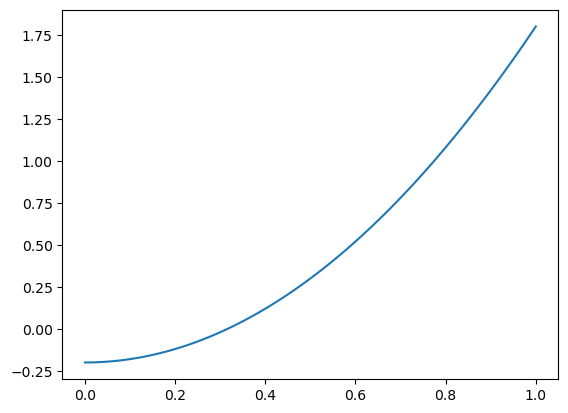

In [116]:
a = np.linspace(0,1,100)
b= -0.2 + 2*a**2
plt.plot(a,b)

Train Functions to original metrics, evaluate how far off we are on test data with original normalization

Other Ideas:

Accuracy (In order of increasing difficulty):

-Incorporate as feature how many possible chem structures (can also restrict to NPS) exist within a certain precursor distance. (violating golden rules or not)

-include original NIST version or theoretical res as feature

-Weight different ranges of spec differently for matches (more diversity/greater accuracy)

-smush together top n results over different inchicores and come up with combined model predicting over individual inchicores

-diagnostic ion/loss classing as a feature...do they match

-kernelized smooth match

-3d struct guesses...do they match (cores, but can generalize to 3d)

Speed(In order of increasing difficulty):

-combine sim metrics and expand(apply func to df)

-exclude matches based on non-similarity features to cut down on needed comparisons

-ion tables to upper bound similarity

-only use one peak consolidation and matching protocol...then only do reweight transformations on already matched peaks for spec and sim features

-can missing peaks in lower energy be explained by frags and losses from higher energy? incorporate into model

Order to proceed:

-recreate databases with coll energy included (standardized format across DBs)

-what proportion of matches are the same coll energy?

-quantify variability in peak appearance vs peak intensity across collision energies
    -does this relate in a predictable way to fragment mass

-test sim metrics for same coll energy vs not same col energy (is the same inductive bias useful)

-Show that regular funcs are in the space of combo distance

-test combining individual metrics that use different components of the 2 vectors (add, mult, dif)

-range over individual metrics in combined score in attempt to explain why combining them is successful

-train combo metrics with flattened components and individual (should these sims be broken out?)
    -should we do this for same coll energy vs dif energies

-are different combo metrics put into larger model more successful than the combined individual metrics

-can tunasims be fit with nonlinearities between the components (flattened or not?)